In [1]:
%matplotlib inline
from Visualization import give_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
sns.set()
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_all = give_data(['Source', 'Month', 'Brand', 'Model', 'SALES THS.USD'])# читаємо та обробляємо
data_all = data_all[data_all['Source'] == 'Traditional Sales']
data_all = data_all[data_all['Brand'] == 'SAMSUNG']

In [3]:
data = data_all[data_all['Model'] == 'RB37J5000SA/UA']
data.head()

,Source,Month,Brand,Model,SALES THS.USD
3,Traditional Sales,2018-01-01,SAMSUNG,RB37J5000SA/UA,297.090130
1709,Traditional Sales,2018-02-01,SAMSUNG,RB37J5000SA/UA,290.733918
3290,Traditional Sales,2018-03-01,SAMSUNG,RB37J5000SA/UA,388.535457
4918,Traditional Sales,2018-04-01,SAMSUNG,RB37J5000SA/UA,361.447581
6592,Traditional Sales,2018-05-01,SAMSUNG,RB37J5000SA/UA,476.815415


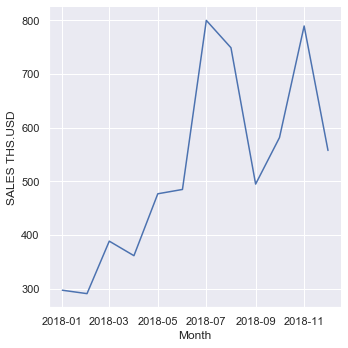

In [4]:
sns.relplot(x='Month', y='SALES THS.USD',kind='line', data=data)# візуалізація

In [5]:
otg = data[['Month', 'SALES THS.USD']]# обробка
otg = otg.set_index('Month')
otg.index = otg.index.to_period(freq='M')
itog = otg.describe()
itog

,SALES THS.USD
count,12.000000
mean,522.655968
std,180.137389
min,290.733918
25%,381.763488
50%,489.869428
75%,623.401447
max,799.944728


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14F66400>]],
      dtype=object)

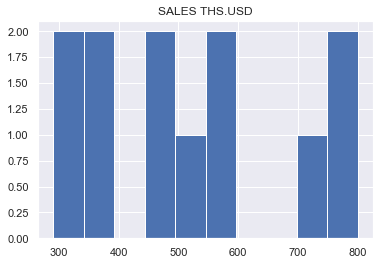

In [6]:
otg.hist()

In [ ]:
res = []#пошук параметру для SimpleExpSmoothing
for i in range(1000):
    fit3 = SimpleExpSmoothing(otg).fit(smoothing_level=i/1000,optimized=False)
    res += [[i/1000, ((otg['SALES THS.USD']- fit3.fittedvalues)**2).sum()]]
res = sorted(res, key=lambda x: x[1])
print(res[0])

In [ ]:
res = []#пошук параметру для Holt
for i in range(100):
    for j in range(100):
        fit3 = Holt(otg).fit(smoothing_level=j/100, smoothing_slope=i/100)
        res += [[[j/100, i/100], fit3.aic]]
res = sorted(res, key=lambda x: x[1])
print(res[0])

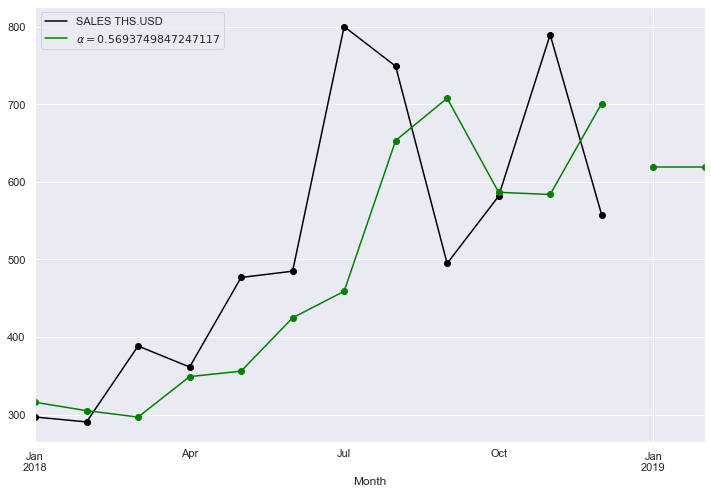

In [7]:
#прогноз за допомогою SimpleExpSmoothing
fit1 = SimpleExpSmoothing(otg).fit()
fcast1 = fit1.forecast(2).rename(r'$\alpha=%s$'%fit1.model.params['smoothing_level'])
ax = otg.plot(marker='o', color='black', figsize=(12,8))
fcast1.plot(marker='o', ax=ax, color='green', legend=True)
fit1.fittedvalues.plot(marker='o', ax=ax, color='green')
plt.show()

129.76839295984024
128.53968356046659
129.8440625068727


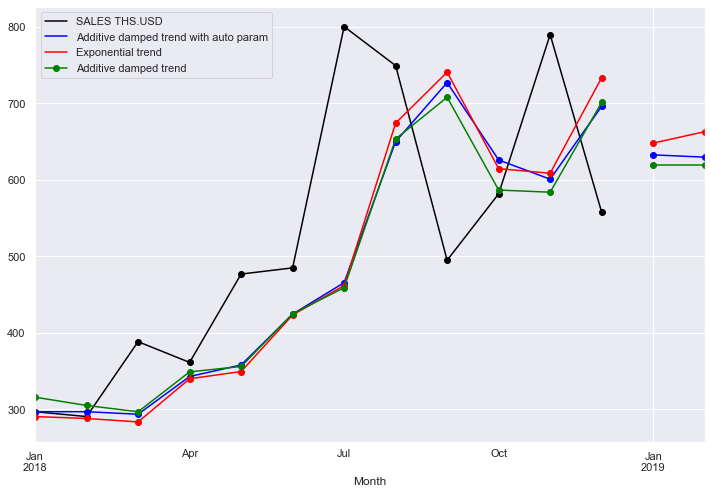

In [8]:
fit1 = Holt(otg, damped=True).fit()
fcast1 = fit1.forecast(2).rename("Additive damped trend with auto param")
print(fit1.aic)
fit2 = Holt(otg, exponential=True).fit(smoothing_level=0.5693, smoothing_slope=0.053, optimized=False)
fcast2 = fit2.forecast(2).rename("Exponential trend")
print(fit2.aic)
fit3 = Holt(otg, damped=True, exponential=True).fit()
fcast3 = fit3.forecast(2).rename("Additive damped trend")
print(fit3.aic)
ax = otg.plot(marker='o', color='black', figsize=(12,8))
fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(marker="o", color='red')
fcast2.plot(color='red', marker="o", legend=True)
fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)
plt.show()

In [9]:
fit1 = SimpleExpSmoothing(otg).fit()
fit2 = Holt(otg).fit()
fit3 = Holt(otg,exponential=True).fit()
fit4 = Holt(otg,damped=True).fit()
fit5 = Holt(otg,exponential=True,damped=True).fit()
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'initial_level', 'initial_slope']
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$l_0$","$b_0$","SSE"] ,columns=['SES', "Holt's","Exponential", "Additive", "Multiplicative"])
results["SES"] =            [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's"] =         [fit2.params[p] for p in params] + [fit2.sse]
results["Exponential"] =    [fit3.params[p] for p in params] + [fit3.sse]
results["Additive"] =       [fit4.params[p] for p in params] + [fit4.sse]
results["Multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]
results

,SES,Holt's,Exponential,Additive,Multiplicative
$\alpha$,0.569375,4.227934e-12,0.018429,0.421053,5.693762e-01
$\beta$,NaN,2.072015e-13,0.000000,0.421053,1.079323e-07
$\phi$,NaN,NaN,NaN,0.578947,8.804671e-06
$l_0$,316.051420,2.842174e+02,297.090086,297.090130,3.160490e+02
$b_0$,NaN,3.667604e+01,1.073475,0.000000,1.135761e+05
SSE,260905.058258,1.640623e+05,201567.646448,259265.020607,2.609051e+05


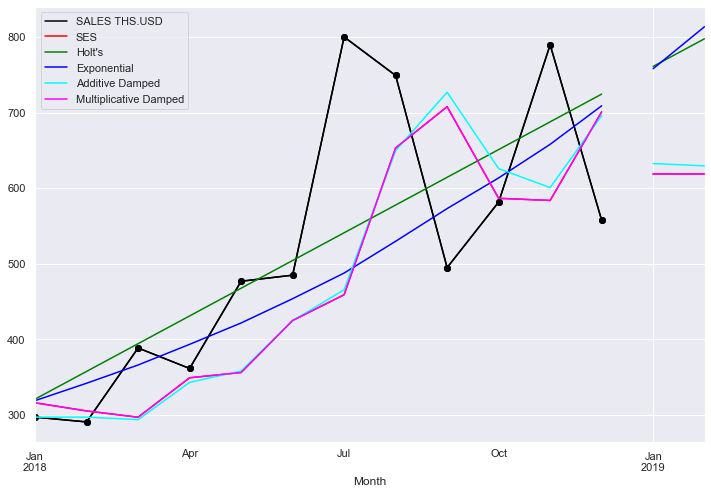

In [10]:
fit1 = SimpleExpSmoothing(otg).fit()
fcast1 = fit1.forecast(2).rename("SES")
fit2 = Holt(otg).fit()
fcast2 = fit2.forecast(2).rename("Holt's")
fit3 = Holt(otg, exponential=True).fit()
fcast3 = fit3.forecast(2).rename("Exponential")
fit4 = Holt(otg, damped=True).fit()
fcast4 = fit4.forecast(2).rename("Additive Damped")
fit5 = Holt(otg, exponential=True, damped=True).fit()
fcast5 = fit5.forecast(2).rename("Multiplicative Damped")

ax = otg.plot(color="black", marker="o", figsize=(12,8))
otg.plot(ax=ax, color="black", marker="o", legend=False)
fcast1.plot(ax=ax, color='red', legend=True)
fit1.fittedvalues.plot(ax=ax, color='red')
fcast2.plot(ax=ax, color='green', legend=True)
fit2.fittedvalues.plot(ax=ax, color='green')
fcast3.plot(ax=ax, color='blue', legend=True)
fit3.fittedvalues.plot(ax=ax, color='blue')
fcast4.plot(ax=ax, color='cyan', legend=True)
fit4.fittedvalues.plot(ax=ax, color='cyan')
fcast5.plot(ax=ax, color='magenta', legend=True)
fit5.fittedvalues.plot(ax=ax, color='magenta')
plt.show()

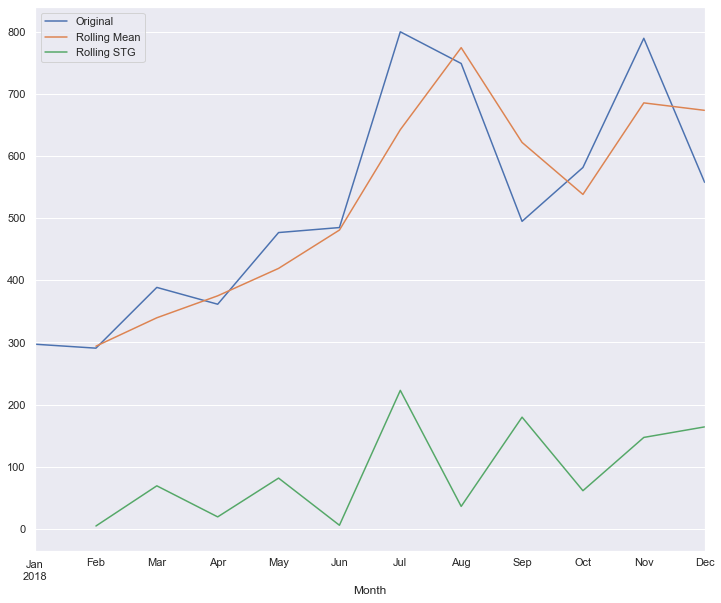

In [11]:
rolmean = otg.rolling(2).mean()
rolstd = otg.rolling(2).std()
fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
otg.plot(fig=fig, ax=axes)
rolmean.plot(fig=fig, ax=axes)
rolstd.plot(fig=fig, ax=axes)
plt.legend(['Original','Rolling Mean','Rolling STG'])

In [12]:
print('V = ' + str(itog.loc['std'][0]/itog.loc['mean'][0]))

V = 0.34465767161826155


In [13]:
row =  ['JB', 'p-value', 'skew', 'kurtosis']# тест Jarque–Bera
jb_test = sm.stats.stattools.jarque_bera(otg)
a = [np.hstack(jb_test)]
itog = SimpleTable(a, row)
itog

JB,p-value,skew,kurtosis
0.8543138956950858,0.6523611575133034,0.3481812212416117,1.893787027698115


In [14]:
test = sm.tsa.adfuller(otg['SALES THS.USD'])#тест Дікі-Фулера
print('adf: ' + str(test[0]))
print('p-value: ' + str(test[1]))
print('Critical values: ' + str(test[4]))
if test[0]> test[4]['5%']: 
    print('є одиничні корені, ряд не є стаціонарним')
else:
    print('одиничних коренів нема, ряд є стаціонарним')

adf: -1.899512524773052
p-value: 0.3322904691961855
Critical values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
є одиничні корені, ряд не є стаціонарним


In [15]:
otg1diff = otg.diff(periods=1).dropna()# беремо різниці першого порядку

In [16]:
test = sm.tsa.adfuller(otg1diff['SALES THS.USD'])
print('adf: ' + str(test[0]))
print('p-value: ' + str(test[1]))
print('Critical values: ' + str(test[4]))
if test[0]> test[4]['5%']: 
    print('є одиничні корені, ряд не є стаціонарним')
else:
    print('одиничних коренів нема, ряд є стаціонарним')

adf: -3.5314505398036764
p-value: 0.007215174361484475
Critical values: {'1%': -4.473135048010974, '5%': -3.28988060356653, '10%': -2.7723823456790124}
одиничних коренів нема, ряд є стаціонарним


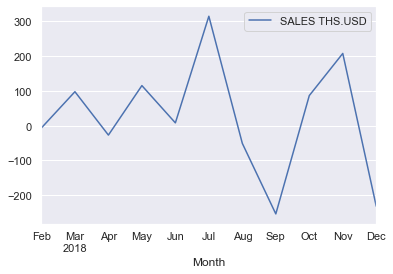

In [17]:
otg1diff.plot()

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

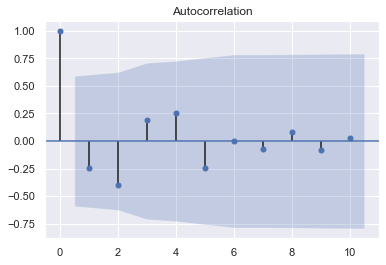

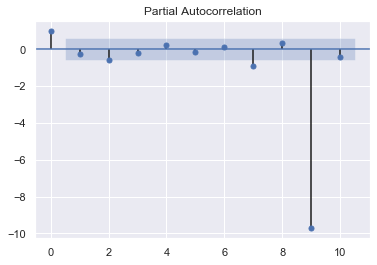

In [18]:
sm.graphics.tsa.plot_acf(otg1diff.values.squeeze()), sm.graphics.tsa.plot_pacf(otg1diff)# ACF & PACF

In [19]:
model = sm.tsa.ARIMA(otg, order=(7,1,0), freq='M').fit(full_output=False)# Побудова моделі

In [20]:
def evaluate_models(dataset, p_values, d_values, q_values):# пошук найкращої моделі
    best_score, best_cfg = 1e9, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse =sm.tsa.ARIMA(dataset, order=order, freq='M').fit().aic
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
evaluate_models(otg, [0,1,2,3,4,5,6,7,8,9], [1], [0,1,2,3,4,5,6,7,8,9])

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.SALES THS.USD   No. Observations:                   11
Model:                 ARIMA(7, 1, 0)   Log Likelihood                 -56.508
Method:                       css-mle   S.D. of innovations              6.781
Date:                Sun, 02 Feb 2020   AIC                            131.016
Time:                        18:03:25   BIC                            134.597
Sample:                    02-28-2018   HQIC                           128.758
                         - 12-31-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    37.0388      0.427     86.824      0.000      36.203      37.875
ar.L1.D.SALES THS.USD    -1.0652      0.032    -33.684      0.000      -1.127      -1.003
ar.L2.D.SALES THS.USD    -1.4313      0.031    -45.784      0.000      -1.493      -1.370
ar.L3.D.SALES THS.USD    -1.1335      0.039    -28.984      0.000      -1.210      -1.057
ar.L4.D.SALES THS.USD    -1.1333      0.039    -28.972      0.000      -1.210      -1.057
ar.L5.D.SALES THS.USD    -1.4317      0.031    -45.711      0.000      -1.493      -1.370
ar.L6.D.SALES THS.USD    -1.0646      0.032    -33.714      0.000      -1.127      -1.003
ar.L7.D.SALES THS.USD    -0.9968        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6735           -0.7393j            1.0001           -0.1324
AR.2            0.6735           +0.7393j            1.0001            0.1324
AR.3           -1.0004           -0.0000j            1.0004           -0.5000
AR.4           -0.5929           -0.8064j            1.0009           -0.3509
AR.5           -0.5929           +0.8064j            1.0009            0.3509
AR.6           -0.1145           -0.9939j            1.0004           -0.2683
AR.7           -0.1145           +0.9939j            1.0004            0.2683
-----------------------------------------------------------------------------
"""

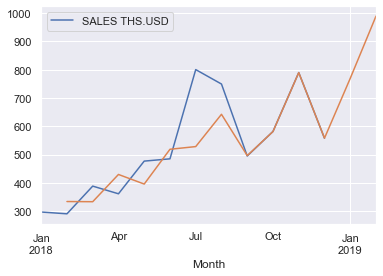

In [22]:
preds =  model.predict(pd.to_datetime("2018-02"), pd.to_datetime("2019-02"), typ='levels')# прогноз
ax = otg.plot()
preds.plot(ax=ax)

In [23]:
from sklearn.metrics import r2_score
pred = model.predict(pd.to_datetime("2018-02"), pd.to_datetime("2018-12"), typ='levels')
trn = otg['2018-02':]
r2 = r2_score(trn, pred)
print('R^2: %1.2f'%r2)

R^2: 0.66
